In [78]:
import pandas as pd
import seaborn as sns
import numpy as np
import re

from utils import *
from matplotlib import pyplot as plt
from pymongo import MongoClient

### Parâmetros do Matplot, Seaborn e Pandas

In [79]:
%matplotlib inline
pd.options.mode.chained_assignment = None 
plt.rcParams['figure.figsize'] = [10, 5]
sns.set(rc={'figure.figsize':(15,10)})

pd.set_option('display.max_columns', 50)

### Recuperação de Datasets do MongoDB

In [80]:
df_meteorologia_2010_2019 = mongo_to_dataframe("meteorologia_2010_2019")

In [81]:
df_acidentes_fatais_2008_2017 = mongo_to_dataframe("acidentes_fatais_2008_2017")

In [82]:
df_acidentes_rodovias_2010_2019 = mongo_to_dataframe("acidentes_rodovias_2010_2019")

In [83]:
df_infracoes_prf_2010_2018 = mongo_to_dataframe("infracoes_prf_2010_2018")

In [84]:
df_infracoes_der_2018_2019 = mongo_to_dataframe("infracoes_der_2018_2019")

## Análise dos acidentes fatais em relação com condições climáticas

In [85]:
dict_meses = {1: 'Janeiro',
              2: 'Fevereiro',
              3: 'Março',
              4: 'Abril',
              5: 'Maio',
              6: 'Junho',
              7: 'Julho',
              8: 'Agosto',
              9: 'Setembro',
              10: 'Outubro',
              11: 'Novembro',
              12: 'Dezembro'}

Text(0, 0.5, 'Precipitação (mm)')

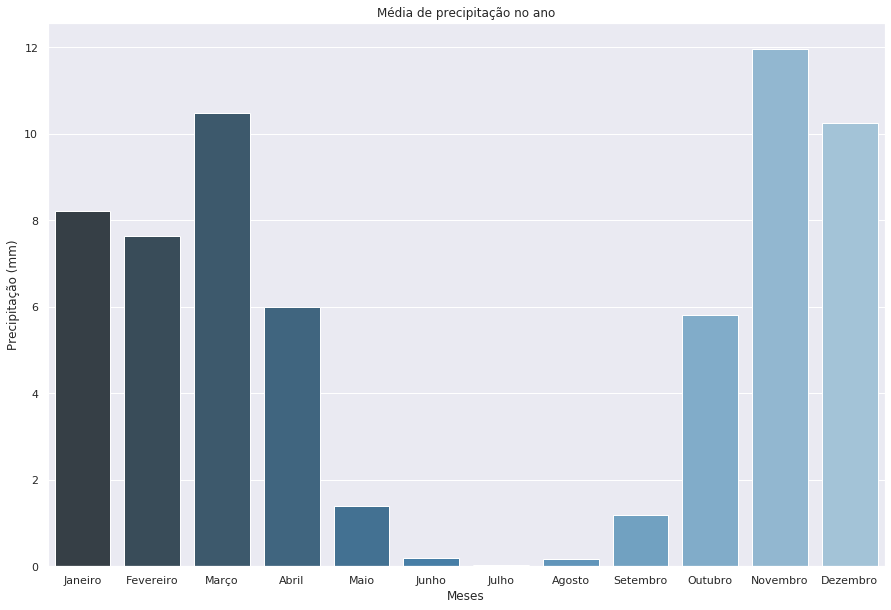

In [86]:
df_meteorologia_2010_2019['Mes'] = df_meteorologia_2010_2019['Data'].dt.month
media_precipitacao_meses = df_meteorologia_2010_2019.groupby('Mes').mean().reset_index()
media_precipitacao_meses = media_precipitacao_meses[['Mes', 'Precipitacao']]

media_precipitacao_meses['Mes'] = media_precipitacao_meses['Mes'].replace(dict_meses)
sns.barplot(x = media_precipitacao_meses['Mes'],
            y = media_precipitacao_meses['Precipitacao'],
            data = media_precipitacao_meses,
            palette = "Blues_d")
plt.title("Média de precipitação no ano")
plt.xlabel("Meses")
plt.ylabel("Precipitação (mm)")

In [87]:
historico_precipitacao_meses = df_meteorologia_2010_2019
historico_precipitacao_meses['Ano'] = historico_precipitacao_meses['Data'].dt.year
historico_precipitacao_meses['Mes Ano'] = historico_precipitacao_meses['Mes'] * 10000 + historico_precipitacao_meses['Ano']
historico_precipitacao_meses = historico_precipitacao_meses.groupby('Mes Ano').mean().reset_index()
historico_precipitacao_meses['Mes'] = historico_precipitacao_meses['Mes'].replace(dict_meses)
historico_precipitacao_meses.head()

,Mes Ano,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Mes,Ano
0,12010,8.770968,28.032258,18.461290,6.848387,4.651613,22.503871,76.000000,2.548387,Janeiro,2010
1,12011,4.612903,27.451613,18.451613,6.545161,3.883871,22.007097,79.701613,3.010753,Janeiro,2011
2,12012,10.238710,25.648387,17.345161,3.703226,2.861290,20.649677,83.548387,2.311828,Janeiro,2012
3,12013,18.996774,26.522581,18.277419,4.245161,3.519355,21.582581,81.629032,2.295699,Janeiro,2013
4,12014,5.719355,28.041935,17.870968,8.432258,5.309677,22.288387,72.491935,2.335818,Janeiro,2014


In [88]:
def plot_precipitacao_meses(meses):
    plot = sns.FacetGrid(meses, col='Mes')
    plot.map(sns.barplot, 'Ano', 'Precipitacao')
    plot.set_xticklabels(rotation=90)

/home/hugo/anaconda3/envs/tcc/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


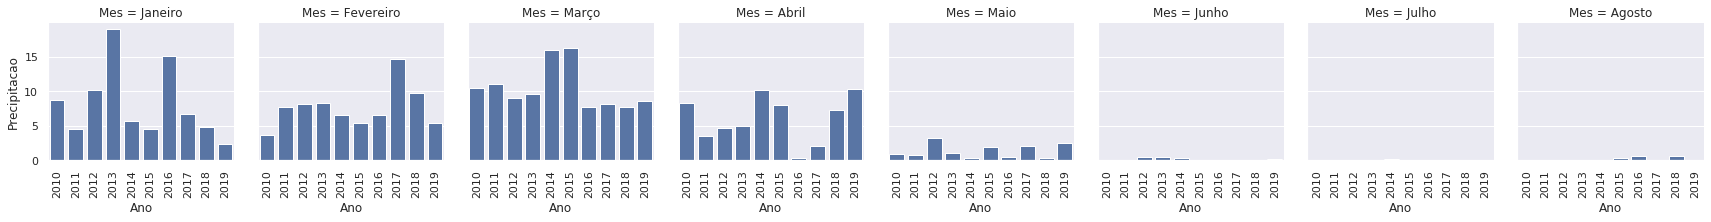

In [89]:
jan_ago = historico_precipitacao_meses.loc[historico_precipitacao_meses['Mes Ano'] <= 82019]
plot_precipitacao_meses(jan_ago)

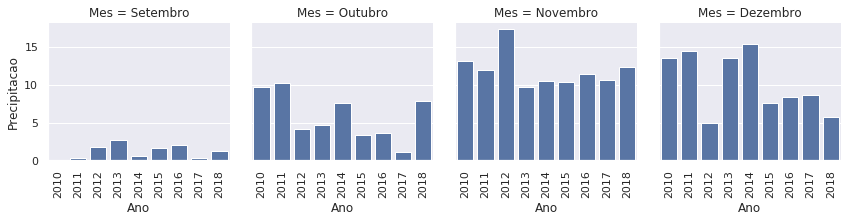

In [90]:
set_dez = historico_precipitacao_meses.loc[historico_precipitacao_meses['Mes Ano'] > 82019]
plot_precipitacao_meses(set_dez)

### Observações
- Os meses com maiores médias de precipitação vão de novembro até março, enquanto a época de estiagem compreende o período de maio a setembro. Abril e outubro são meses que estão entre as estações de secas e chuvas.
- Os índices de precipitação não são constantes no decorrer dos anos a depender do mês. Com isso, dependendo do ano, a ordem dos meses mais chuvosos fica diferente.
- No mês de janeiro é possível observar isso claramente, já que a média de precipitação varia bastante dependendo do ano.

Text(0, 0.5, 'Média de acidentes')

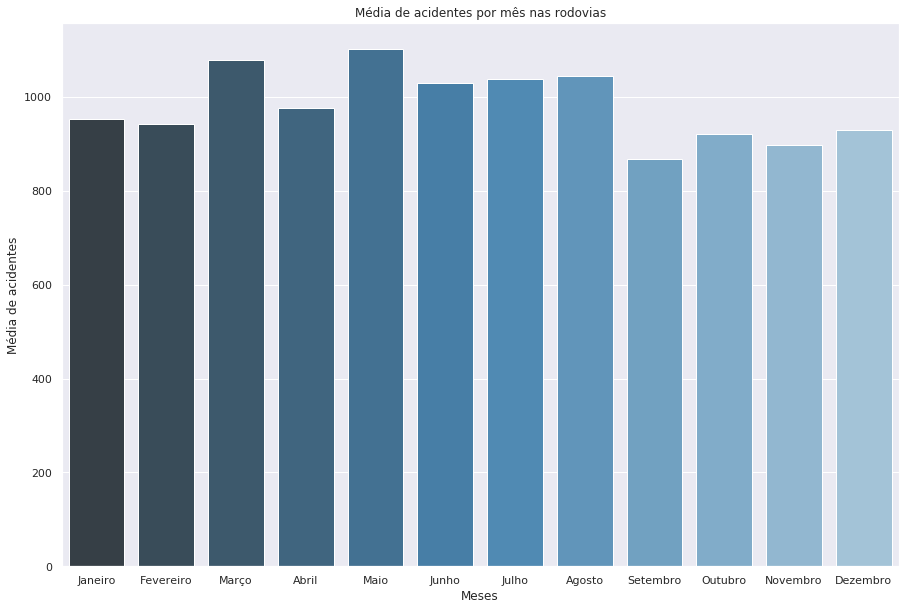

In [113]:
df_acidentes_rodovias_2010_2019['Mes'] = df_acidentes_rodovias_2010_2019['data_inversa'].dt.month
media_acidentes_rodovias_meses = df_acidentes_rodovias_2010_2019.groupby('Mes').count().reset_index()
# media_acidentes_rodovias_meses[media_acidentes_rodovias_meses.Mes <= 7] = media_acidentes_rodovias_meses / 9
# media_acidentes_rodovias_meses[media_acidentes_rodovias_meses.Mes > 7] = media_acidentes_rodovias_meses / 8
media_acidentes_rodovias_meses['Mes'] = media_acidentes_rodovias_meses.index + 1
media_acidentes_rodovias_meses = media_acidentes_rodovias_meses[['Mes', 'causa_acidente']]

media_acidentes_rodovias_meses['Mes'] = media_acidentes_rodovias_meses['Mes'].replace(dict_meses)
sns.barplot(x = media_acidentes_rodovias_meses['Mes'],
            y = media_acidentes_rodovias_meses['causa_acidente'],
            data = media_acidentes_rodovias_meses,
            palette = "Blues_d")
plt.title("Média de acidentes por mês nas rodovias")
plt.xlabel("Meses")
plt.ylabel("Média de acidentes")

In [92]:
df_acidentes_rodovias_2010_2019['condicao_metereologica'].unique().tolist()

['Chuva',
 'Sol',
 'Ceu Claro',
 'Nublado',
 'Ignorada',
 'Nevoeiro/neblina',
 'Vento',
 'Céu Claro           ',
 'Nublado             ',
 'Sol                 ',
 'Chuva               ',
 'Ignorado            ',
 'Garoa/Chuvisco      ',
 'Nevoeiro/Neblina    ',
 'Vento               ',
 'Céu Claro',
 'Garoa/Chuvisco',
 'Ignorado',
 'Nevoeiro/Neblina',
 'Neve',
 'Granizo']

In [93]:
# Substitui string para padronizar determinada coluna do dataframe.
def padroniza_coluna_dataset(dataframe, coluna, nao_padrao, padrao):
    dataframe[coluna] = dataframe[coluna].str.replace(nao_padrao, padrao)

In [94]:
# Os dados de condicoes meteorologicas possuem labels iguais, mas formatadas de maneira diferente.
df_acidentes_rodovias_2010_2019['condicao_metereologica'] = df_acidentes_rodovias_2010_2019['condicao_metereologica'].str.lower()
padroniza_coluna_dataset(df_acidentes_rodovias_2010_2019, 'condicao_metereologica', 'é', 'e')
padroniza_coluna_dataset(df_acidentes_rodovias_2010_2019, 'condicao_metereologica', ' ', '')
padroniza_coluna_dataset(df_acidentes_rodovias_2010_2019, 'condicao_metereologica', 'uc', 'u c')
padroniza_coluna_dataset(df_acidentes_rodovias_2010_2019, 'condicao_metereologica', 'ignorado', 'ignorada')

df_acidentes_rodovias_2010_2019['condicao_metereologica'].unique().tolist()

['chuva',
 'sol',
 'ceu claro',
 'nublado',
 'ignorada',
 'nevoeiro/neblina',
 'vento',
 'garoa/chuvisco',
 'neve',
 'granizo']

In [95]:
# Algumas labels tem vários espaços no final
df_acidentes_rodovias_2010_2019['tipo_acidente'] = df_acidentes_rodovias_2010_2019['tipo_acidente'].str.capitalize()
padroniza_coluna_dataset(df_acidentes_rodovias_2010_2019, 'tipo_acidente', '  ', '-')
padroniza_coluna_dataset(df_acidentes_rodovias_2010_2019, 'tipo_acidente', '- ', '-')
padroniza_coluna_dataset(df_acidentes_rodovias_2010_2019, 'tipo_acidente', '-', '')
df_acidentes_rodovias_2010_2019['tipo_acidente'].unique().tolist()

['Capotamento',
 'Saída de pista',
 'Colisão traseira',
 'Colisão lateral',
 'Colisão transversal',
 'Colisão com objeto fixo',
 'Queda de motocicleta / bicicleta / veículo',
 'Colisão frontal',
 'Atropelamento de pessoa',
 'Atropelamento de animal',
 'Tombamento',
 'Colisão com bicicleta',
 'Incêndio',
 'Danos eventuais',
 'Colisão com objeto móvel',
 'Colisão com objeto estático',
 'Saída de leito carroçável',
 'Queda de ocupante de veículo',
 'Atropelamento de pedestre',
 'Engavetamento',
 'Colisão com objeto em movimento',
 'Derramamento de carga']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

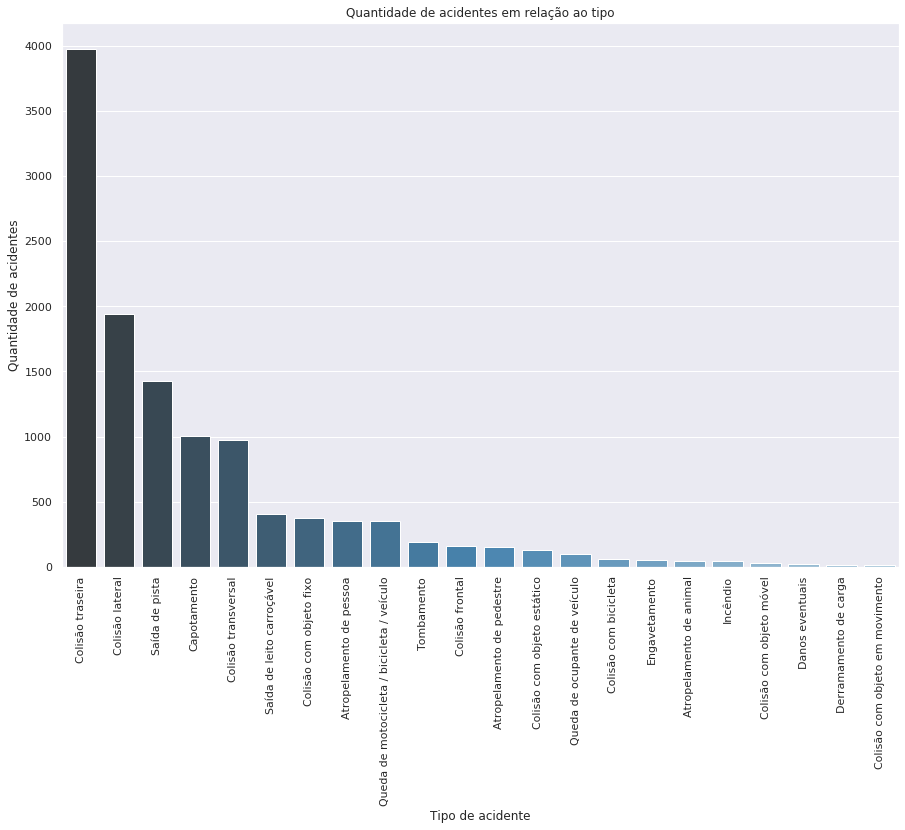

In [96]:
tipos_acidentes = df_acidentes_rodovias_2010_2019.groupby('tipo_acidente').count().reset_index().sort_values('causa_acidente', ascending=False)

sns.barplot(x = tipos_acidentes['tipo_acidente'],
            y = tipos_acidentes['causa_acidente'],
            data = tipos_acidentes,
            palette = "Blues_d")
plt.title("Quantidade de acidentes em relação ao tipo")
plt.xlabel("Tipo de acidente")
plt.ylabel("Quantidade de acidentes")
plt.xticks(rotation=90)

Text(0, 0.5, 'Quantidade de acidentes')

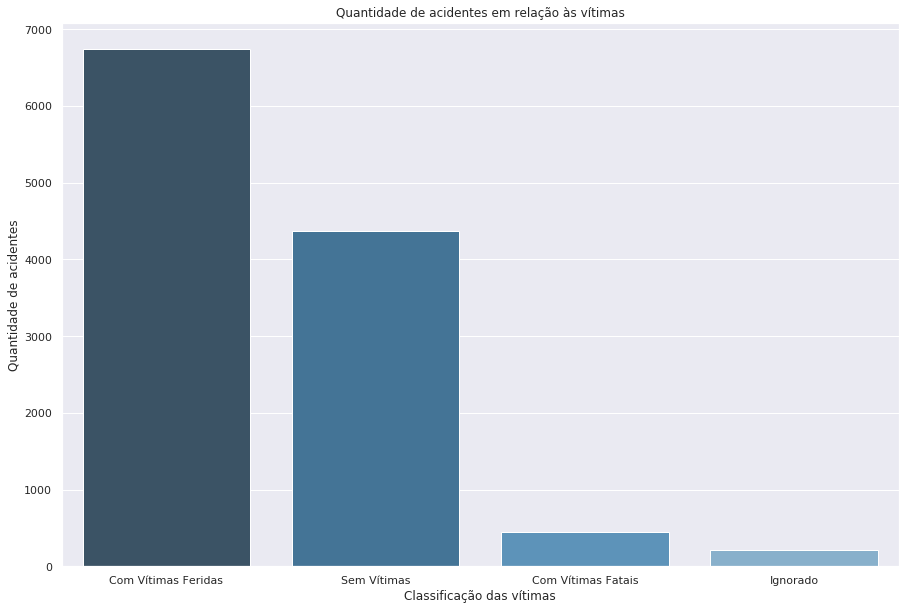

In [120]:
classificacao_vitimas = df_acidentes_rodovias_2010_2019.groupby('classificacao_acidente').count().reset_index().sort_values('causa_acidente', ascending=False)

sns.barplot(x = classificacao_vitimas['classificacao_acidente'],
            y = classificacao_vitimas['causa_acidente'],
            data = classificacao_vitimas,
            palette = "Blues_d")
plt.title("Quantidade de acidentes em relação às vítimas")
plt.xlabel("Classificação das vítimas")
plt.ylabel("Quantidade de acidentes")

### Observações
- A quantidade total de acidentes é relativamente constante de acordo com o mês.
- A maior parte dos acidentes é do tipo colisão traseira. Colisão lateral, saída de pista, capotamento e colisão transversal são as outras ocorrências mais comuns, repectivamente.
- A minoria dos acidentes teve alguma vítima fatal (menos de 500 no período), enquanto a maior parte teve vítimas feridas ou sem vítimas.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

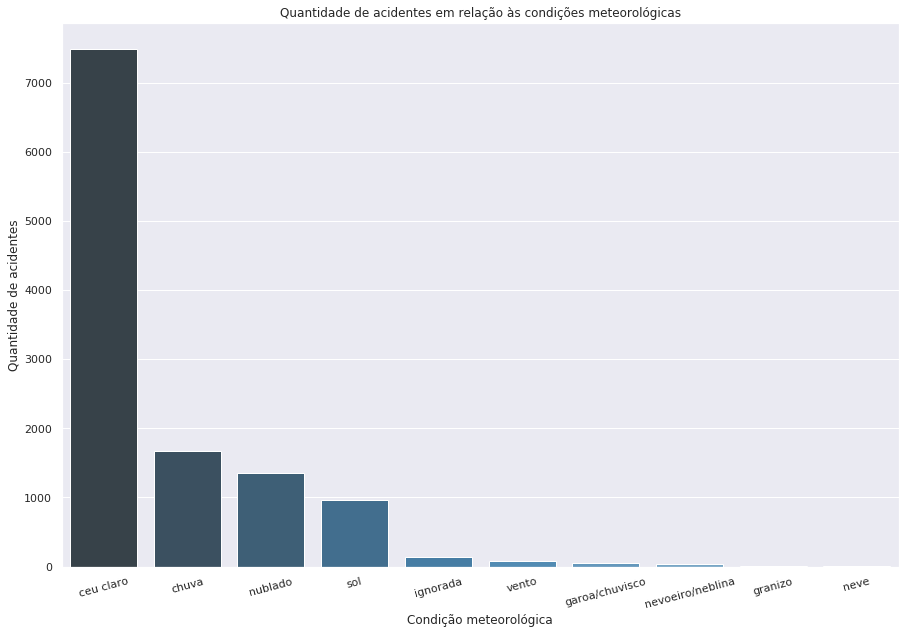

In [99]:
condicoes_metereologicas = df_acidentes_rodovias_2010_2019.groupby('condicao_metereologica').count().reset_index().sort_values('causa_acidente', ascending=False)

sns.barplot(x = condicoes_metereologicas['condicao_metereologica'],
            y = condicoes_metereologicas['causa_acidente'],
            data = condicoes_metereologicas,
            palette = "Blues_d")
plt.title("Quantidade de acidentes em relação às condições meteorológicas")
plt.xlabel("Condição meteorológica")
plt.ylabel("Quantidade de acidentes")
plt.xticks(rotation=15)

In [100]:
lista_neve_granizo = ['neve', 'granizo']
neve_granizo = df_acidentes_rodovias_2010_2019.loc[df_acidentes_rodovias_2010_2019['condicao_metereologica'].isin(lista_neve_granizo)]
neve_granizo

,data_inversa,dia_semana,horario,uf,br,km,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,ano,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,Mes
9529,2012-03-02,Sexta,16:15:00,DF,60.0,0.1,Outras,Colisão com objeto fixo,Ignorado,Plena noite,Decrescente,neve,Dupla,Reta,Urbano,2012,2,0,0,0,0,2,0,1,3
10411,2012-10-13,Sábado,06:15:00,DF,20.0,0,Outras,Saída de pista,Com Vítimas Feridas,Pleno dia,Decrescente,granizo,Dupla,Curva,Rural,2012,1,0,1,0,0,0,1,1,10


In [101]:
def isola_condicao_meteorologica(condicao_meteorologica, agrupamento):
    acidentes_condicao_meteorologica = df_acidentes_rodovias_2010_2019.loc[df_acidentes_rodovias_2010_2019['condicao_metereologica'] == condicao_meteorologica]
    acidentes_condicao_meteorologica = acidentes_condicao_meteorologica.groupby(agrupamento).count().reset_index().sort_values('causa_acidente', ascending=False)
    
    return acidentes_condicao_meteorologica

In [102]:
def barplot_com_subplots(lista_df, lista_df_label, x, y, titulo):
    n_plots = len(lista_df)
    fig, axs = plt.subplots(n_plots, 1, figsize=(30, 20))
    fig.subplots_adjust(hspace=0.9, wspace=0.9)

    i = 0
    for item in lista_df:
        sns.barplot(x = item[x],
                    y = item[y],
                    data = item,
                    palette = "Blues_d",
                    ax = axs[i])
        axs[i].tick_params(labelrotation=90)
        axs[i].set_ylabel('Quantidade')
        axs[i].set_xlabel('')
        axs[i].set_title(lista_df_label[i])
        i += 1

    fig.suptitle(titulo, fontsize=25)
    plt.xlabel("")
    plt.show()

In [103]:
def plota_acidentes_condicao_meteorologica(agrupamento, titulo):
    acidentes_condicao_ceu_claro = isola_condicao_meteorologica('ceu claro', agrupamento)
    acidentes_condicao_chuvosa = isola_condicao_meteorologica('chuva', agrupamento)
    acidentes_condicao_nublada = isola_condicao_meteorologica('nublado', agrupamento)
    acidentes_condicao_ensolarada = isola_condicao_meteorologica('sol', agrupamento)

    lista_df_acidentes = [acidentes_condicao_ceu_claro,
                          acidentes_condicao_chuvosa,
                          acidentes_condicao_nublada,
                          acidentes_condicao_ensolarada]
    lista_condicao_meteorologica = ['Céu claro', 'Chuva', 'Nublado', 'Sol']
    barplot_com_subplots(lista_df_acidentes, lista_condicao_meteorologica, agrupamento, 'causa_acidente', titulo)

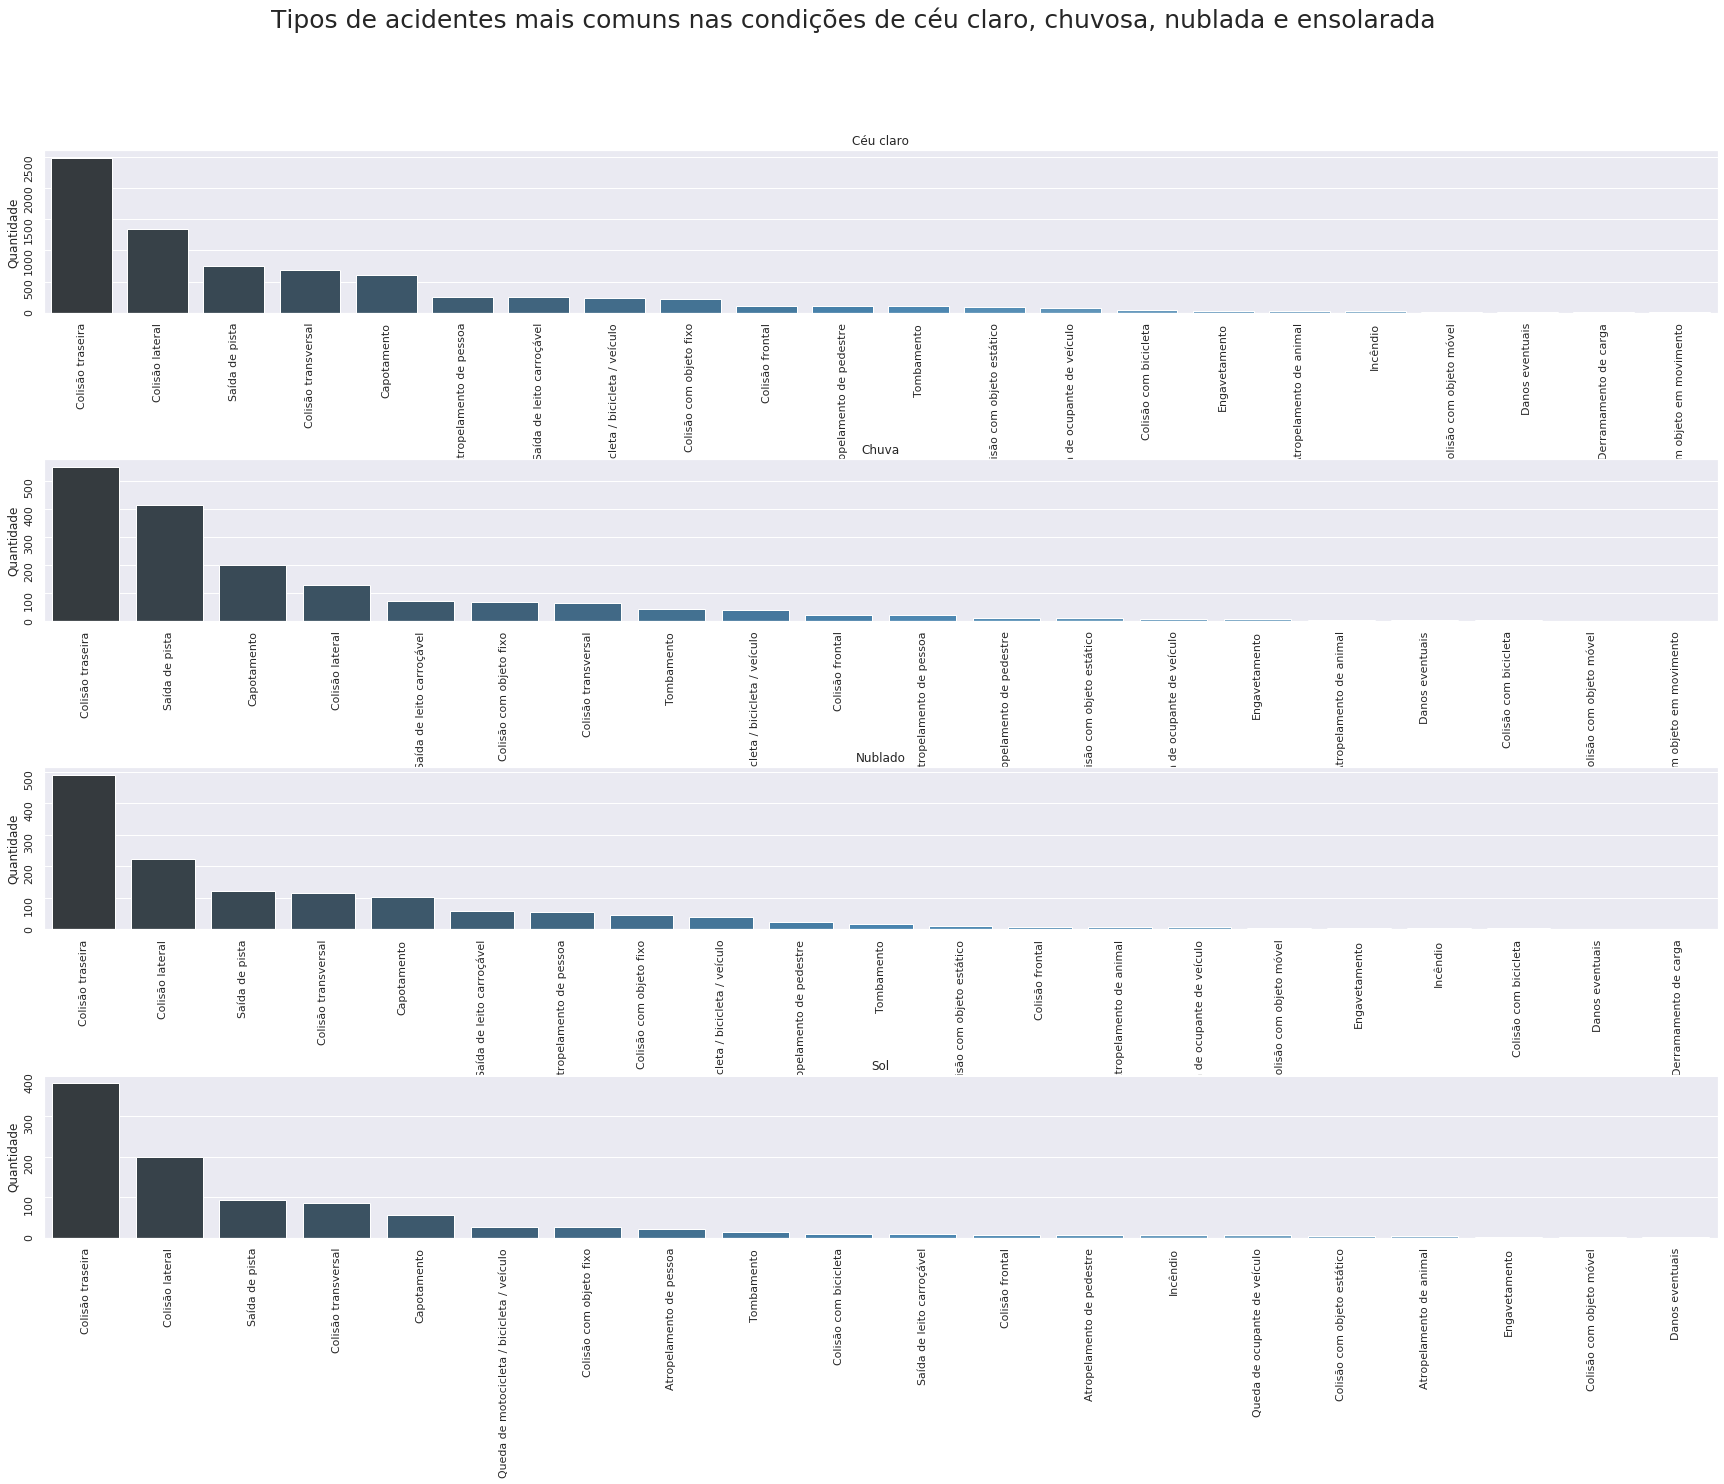

In [104]:
titulo = "Tipos de acidentes mais comuns nas condições de céu claro, chuvosa, nublada e ensolarada"
plota_acidentes_condicao_meteorologica('tipo_acidente', titulo)

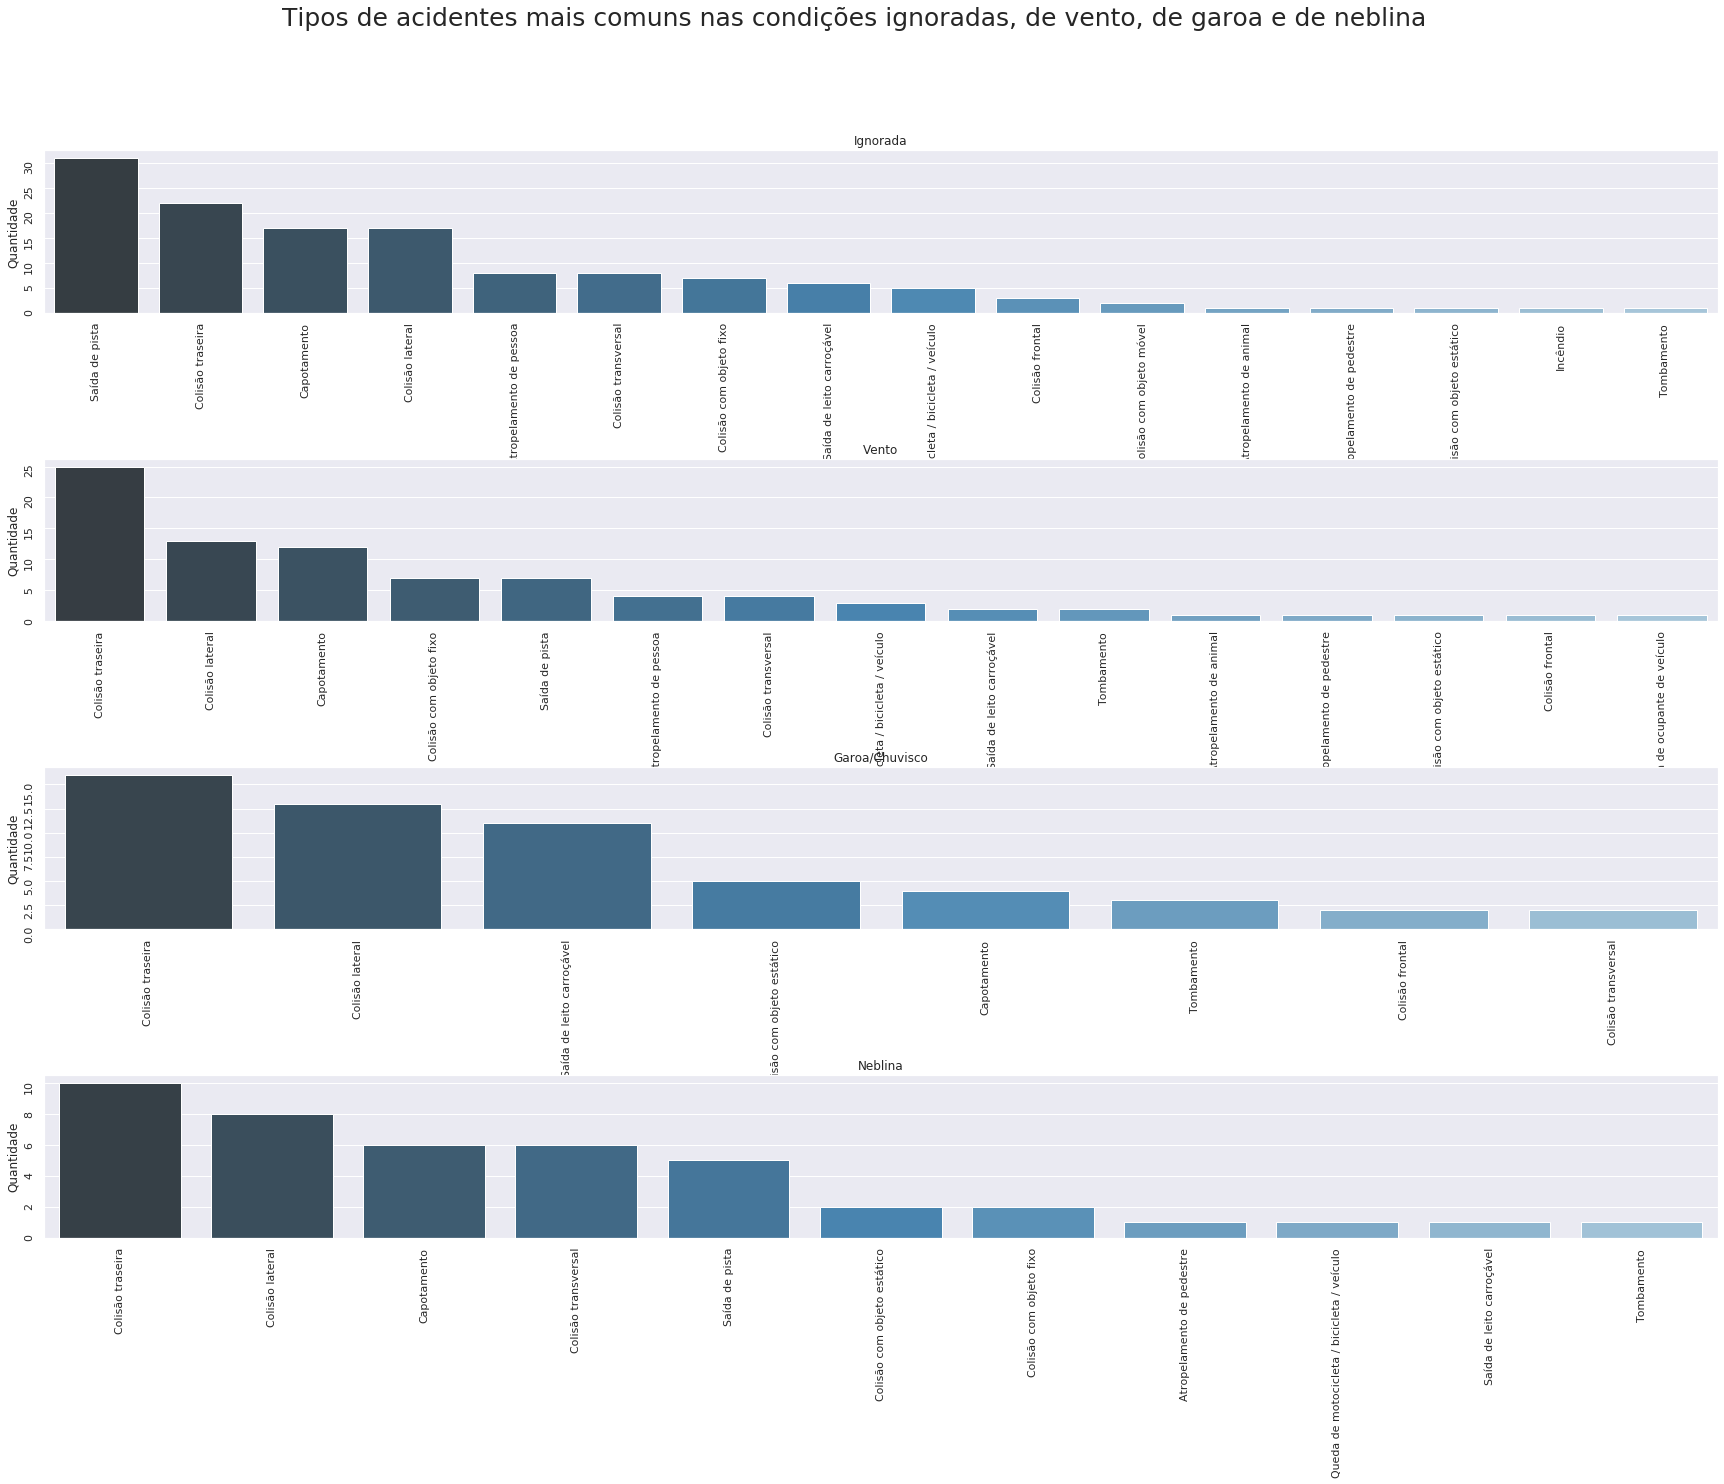

In [105]:
acidentes_condicao_ignorada = isola_condicao_meteorologica('ignorada', 'tipo_acidente')
acidentes_condicao_vento = isola_condicao_meteorologica('vento', 'tipo_acidente')
acidentes_condicao_garoa = isola_condicao_meteorologica('garoa/chuvisco', 'tipo_acidente')
acidentes_condicao_neblina = isola_condicao_meteorologica('nevoeiro/neblina', 'tipo_acidente')

lista_df_acidentes = [acidentes_condicao_ignorada,
                      acidentes_condicao_vento,
                      acidentes_condicao_garoa,
                      acidentes_condicao_neblina]
lista_condicao_meteorologica = ['Ignorada', 'Vento', 'Garoa/Chuvisco', 'Neblina']
titulo = "Tipos de acidentes mais comuns nas condições ignoradas, de vento, de garoa e de neblina"
barplot_com_subplots(lista_df_acidentes, lista_condicao_meteorologica, 'tipo_acidente', 'causa_acidente', titulo)

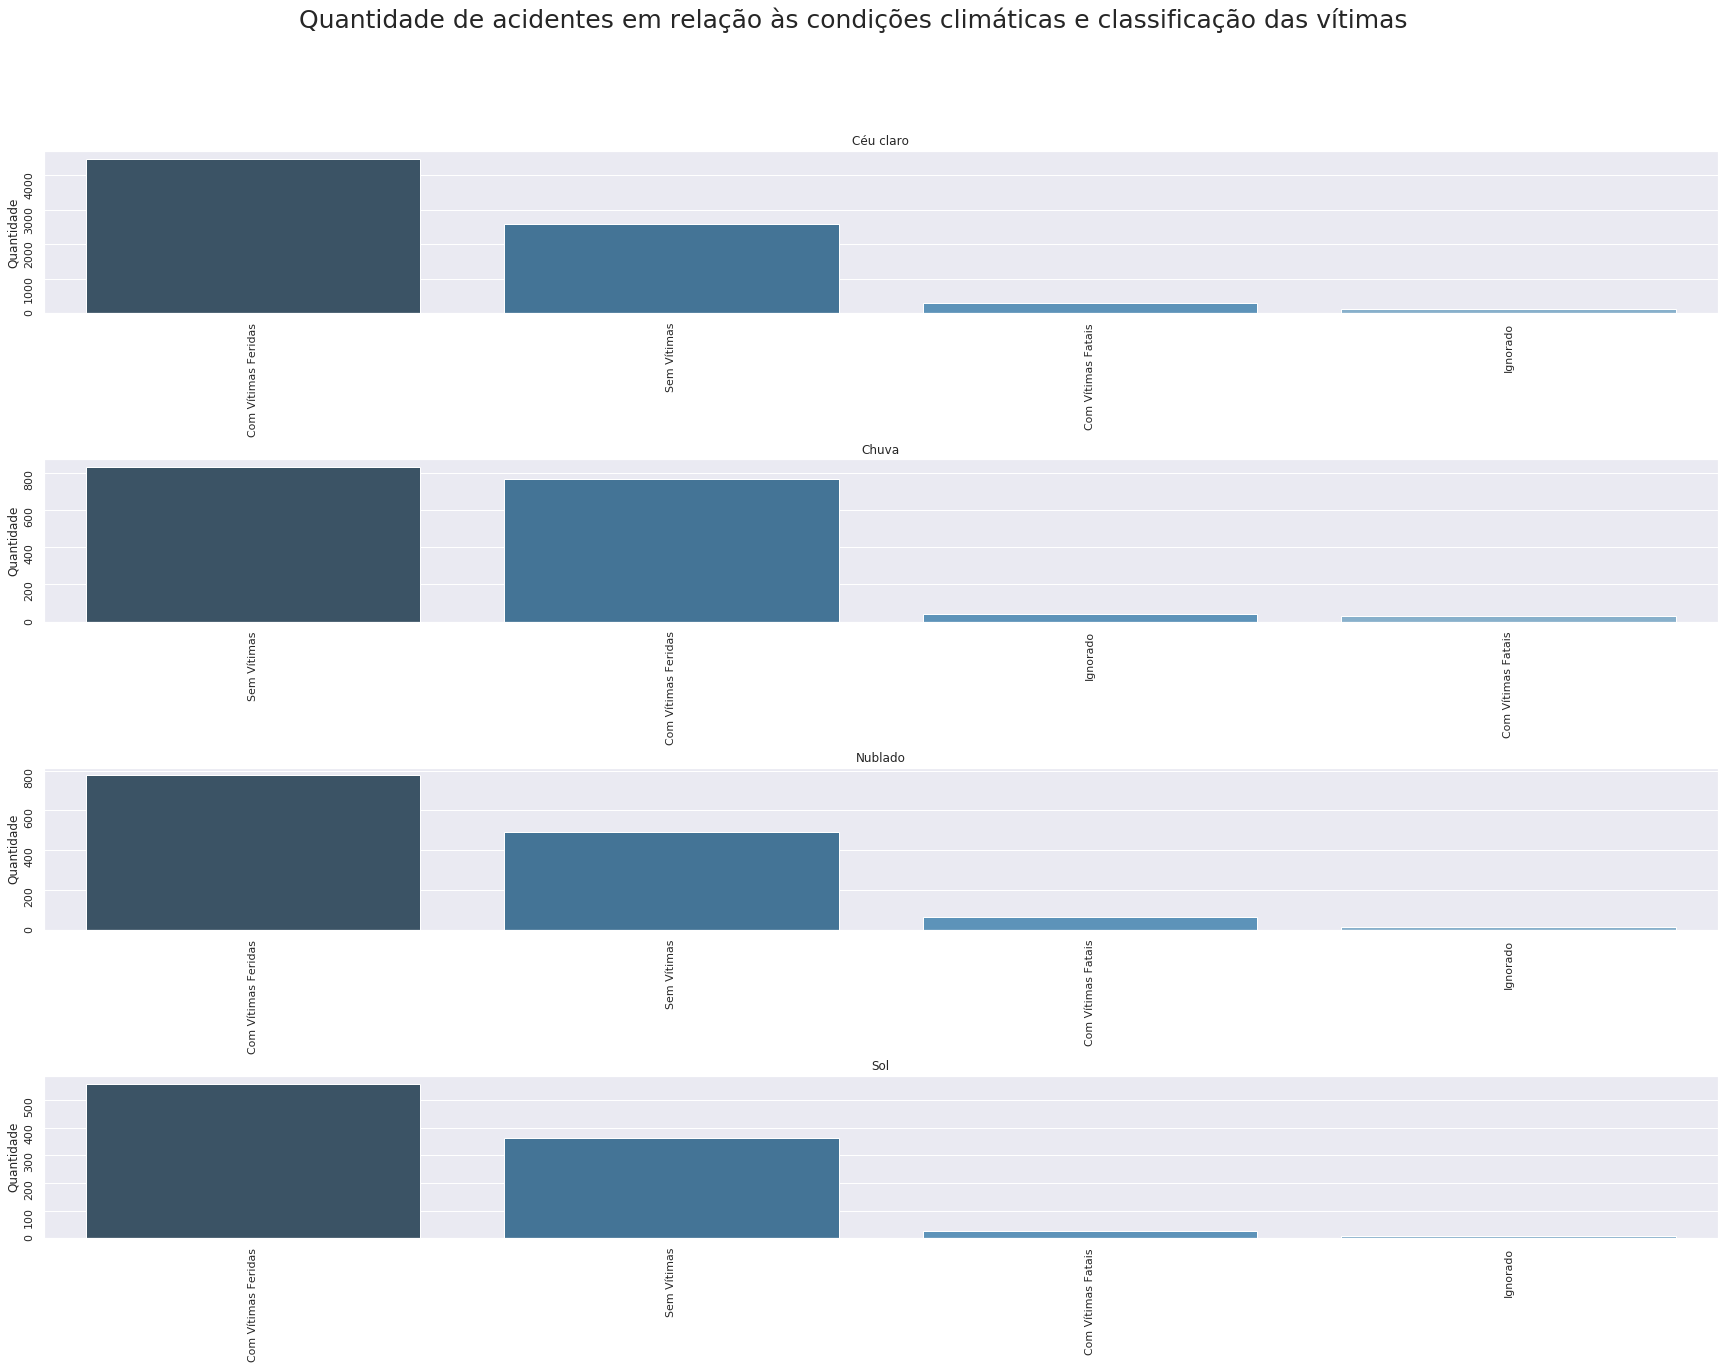

In [106]:
titulo = "Quantidade de acidentes em relação às condições climáticas e classificação das vítimas"
plota_acidentes_condicao_meteorologica('classificacao_acidente', titulo)

### Observações
- A maior parte dos acidentes aconteceu na condição de céu claro. As condições de chuva, nebulosidade e sol foram as seguintes mais relevantes.
- Existe uma ocorrência de um acidente na BR-060 de um acidente cuja condição meteorológica era de neve.
- Nas quatro condições mais comuns, os tipos de acidentes que mais aconteceram foram colisão traseira, lateral e saída de pista. Contudo, na chuva essa ordem é diferente, pois o segundo e terceiro tipo de acidentes mais comuns foram saída de pista e capotamento, respectivamente.
- No que diz respeito às vítimas, nessas condições, acidentes com vítimas feridas são os mais comuns, seguidos por sem vítimas. Na chuva, essa ordem fica invertida, porém o número de ocorrências nesses dois tipos de classificação fica bastante próxima, o que não acontece nos outros casos. 

Text(0, 0.5, 'Média de acidentes fatais')

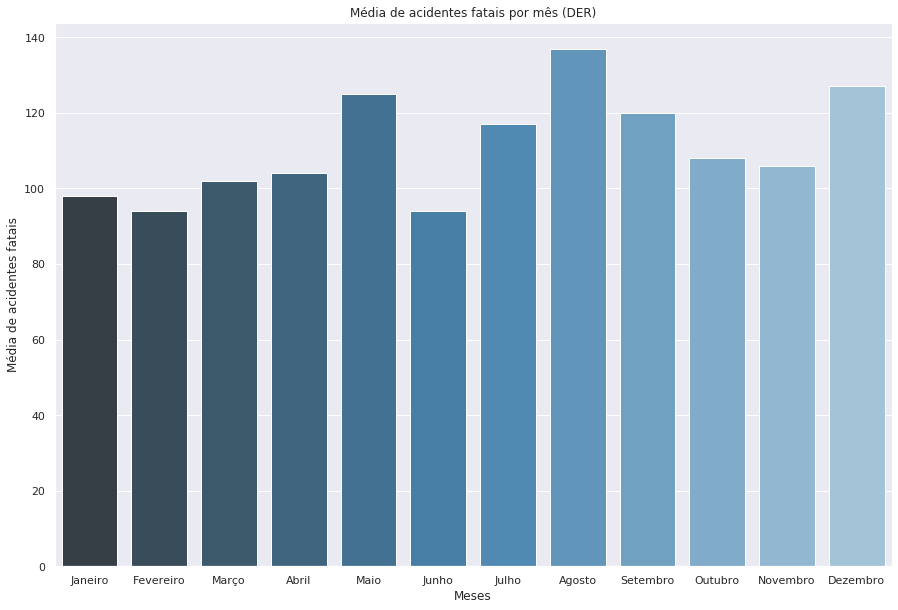

In [117]:
df_acidentes_fatais_2008_2017['Data'] = pd.to_datetime(df_acidentes_fatais_2008_2017['Data'], dayfirst=True)
df_acidentes_fatais_2008_2017['Mes'] = df_acidentes_fatais_2008_2017['Data'].dt.month
media_acidentes_der_meses = df_acidentes_fatais_2008_2017.groupby('Mes').count().reset_index()
# media_acidentes_der_meses['Natureza'] = media_acidentes_der_meses['Natureza'] / 9
media_acidentes_der_meses = media_acidentes_der_meses[['Mes', 'Natureza']]
media_acidentes_der_meses['Mes'] = media_acidentes_der_meses['Mes'].replace(dict_meses)
media_acidentes_der_meses

sns.barplot(x = media_acidentes_der_meses['Mes'],
            y = media_acidentes_der_meses['Natureza'],
            data = media_acidentes_der_meses,
            palette = "Blues_d")
plt.title("Média de acidentes fatais por mês (DER)")
plt.xlabel("Meses")
plt.ylabel("Média de acidentes fatais")

In [108]:
medias_acidentes_precipitacao = pd.merge(media_precipitacao_meses, media_acidentes_rodovias_meses, left_on='Mes', right_on='Mes')
medias_acidentes_precipitacao = medias_acidentes_precipitacao.merge(media_acidentes_der_meses, on='Mes')
medias_acidentes_precipitacao = medias_acidentes_precipitacao.rename(columns={"causa_acidente": "Acidentes Rodovias", "Natureza": "Acidentes Fatais (DER)"})
medias_acidentes_precipitacao

,Mes,Precipitacao,Acidentes Rodovias,Acidentes Fatais (DER)
0,Janeiro,8.204516,106.000000,10.888889
1,Fevereiro,7.641489,104.666667,10.444444
2,Março,10.480645,119.888889,11.333333
3,Abril,6.002333,108.444444,11.555556
4,Maio,1.386774,122.555556,13.888889
5,Junho,0.184333,114.333333,10.444444
6,Julho,0.032581,115.333333,13.000000
7,Agosto,0.170874,130.625000,15.222222
8,Setembro,1.196296,108.375000,13.333333
9,Outubro,5.809319,115.125000,12.000000


In [109]:
def correlaciona_acidentes_precipitacao(acidentes):
    corr_acidentes_precipitacao = medias_acidentes_precipitacao[acidentes].corr(medias_acidentes_precipitacao['Precipitacao'])    

    print('Valor da correlação: {}'.format(corr_acidentes_precipitacao))
    sns.regplot(x = medias_acidentes_precipitacao['Precipitacao'], y = medias_acidentes_precipitacao[acidentes], data = medias_acidentes_precipitacao, fit_reg = True)
    plt.title("Correlação entre a média de precipitação e " + acidentes)
    plt.show()

Valor da correlação: -0.3359042769725179


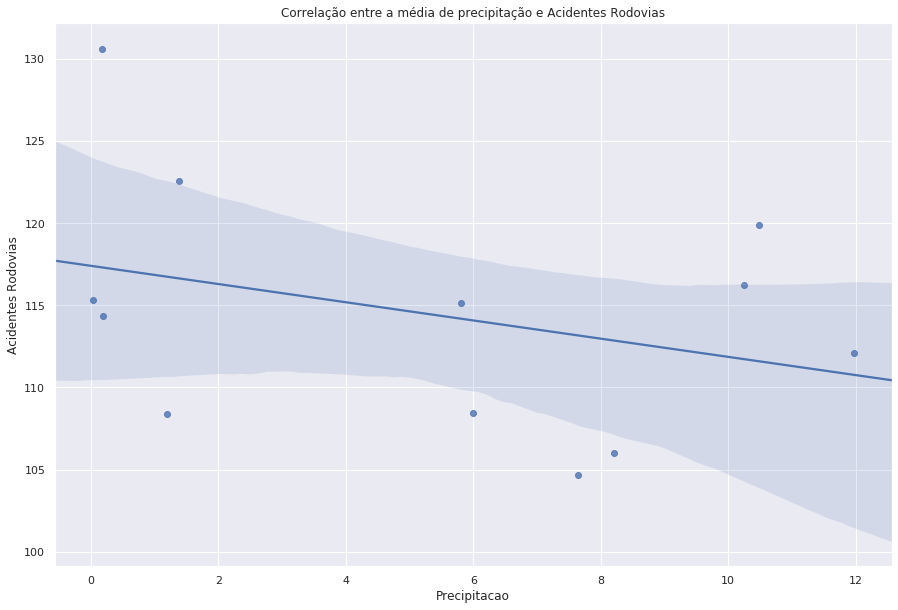

In [110]:
correlaciona_acidentes_precipitacao('Acidentes Rodovias')

Valor da correlação: -0.36704298958002474


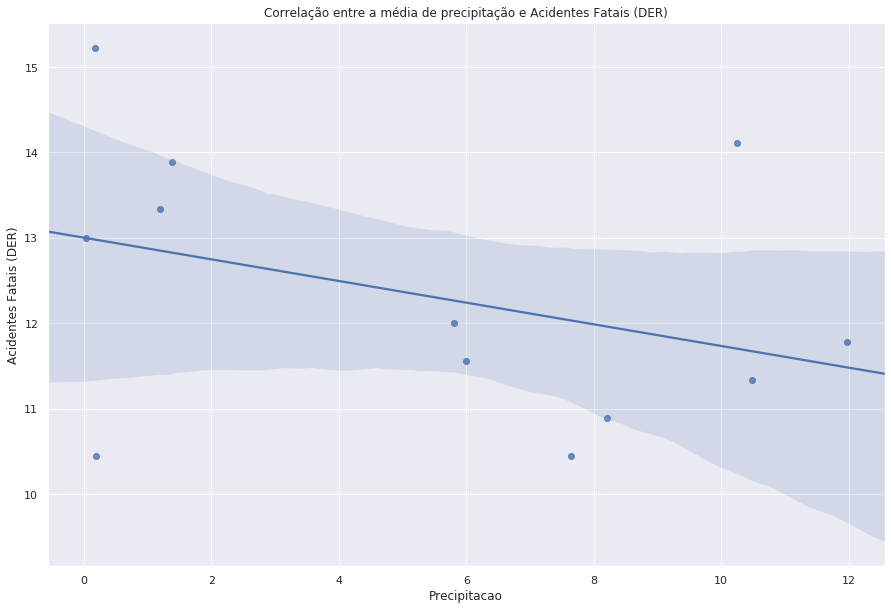

In [111]:
correlaciona_acidentes_precipitacao('Acidentes Fatais (DER)')

### Observações
- A correlação de Pearson, tanto dos acidentes nas rodovias quanto dos dados do DER deram por volta de -0,3. Esse resultado mostra que é uma correlação negativa fraca.
- Com isso, meses com índices de precipitação mais altos não necessariamente são aqueles com mais acidentes.